In [1]:
import yfinance as yf
import pandas as pd

# Define the stock symbols and time period
aapl_symbol = "AAPL"
market_symbol = "^GSPC"  # S&P 500 index
start_date = "2008-01-01"
end_date = "2022-12-31"

# Retrieve the stock data
aapl_data = yf.download(aapl_symbol, start=start_date, end=end_date)
market_data = yf.download(market_symbol, start=start_date, end=end_date)

# Calculate the daily returns
aapl_data["Returns"] = aapl_data["Close"].pct_change()
market_data["Returns"] = market_data["Close"].pct_change()

# Merge the data and keep only the adjusted close column
merged_data = pd.merge(aapl_data["Adj Close"], market_data["Adj Close"], on="Date", suffixes=("_AAPL", "_Market"))
merged_data = merged_data.dropna()
merged_data

merged_data = merged_data.rename(columns={"Adj Close_AAPL": "AAPL", "Adj Close_Market": "Market"})
base_data=merged_data
merged_data


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,AAPL,Market
Date,,
2008-01-02,5.883143,1447.160034
2008-01-03,5.885862,1447.160034
2008-01-04,5.436564,1411.630005
2008-01-07,5.363794,1416.180054
2008-01-08,5.170848,1390.189941
...,...,...
2022-12-23,130.782578,3844.820068
2022-12-27,128.967545,3829.250000
2022-12-28,125.010124,3783.219971


**We start small with one stock (AAPL) and one factor (Market). We shall now use fractional differentiation.**

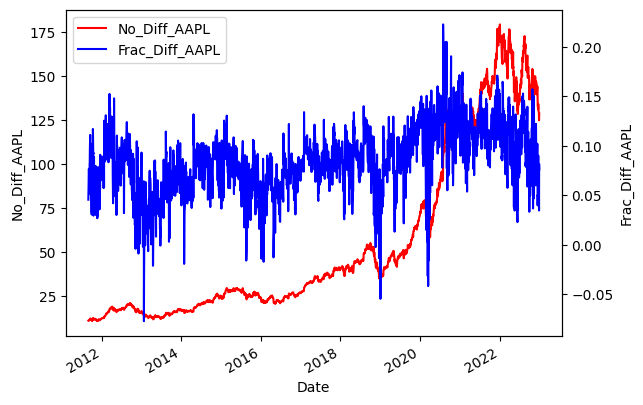

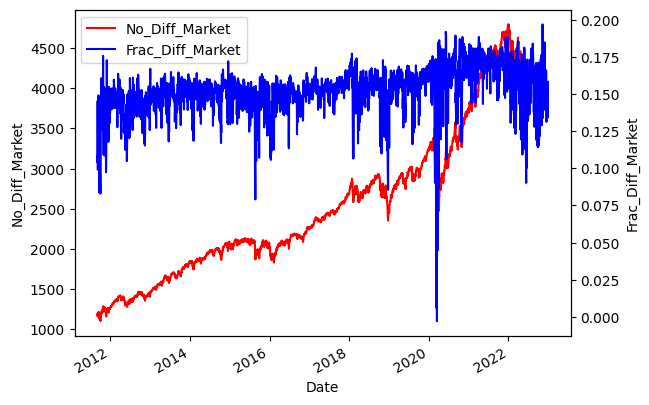

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fracdiff2 import frac_diff_ffd

def plot_multi(data, cols=None, spacing=.1, **kwargs):
    # Get default color style from pandas - can be changed to any other color list
    if cols is None:
        cols = data.columns
    if len(cols) == 0:
        return
    colors = ['r', 'b', 'g']

    # First axis
    ax = data[cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data[cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax


fractional_returns = frac_diff_ffd(merged_data['AAPL'].apply(np.log).values, d=0.5)
merged_data['Frac_Diff_AAPL'] = fractional_returns
merged_data['No_Diff_AAPL'] = merged_data['AAPL']
AAPL_df = merged_data[['No_Diff_AAPL', 'Frac_Diff_AAPL']]


fractional_returns = frac_diff_ffd(merged_data['Market'].apply(np.log).values, d=0.5)
merged_data['Frac_Diff_Market'] = fractional_returns
merged_data['No_Diff_Market'] = merged_data['Market']
Market_df = merged_data[['No_Diff_Market', 'Frac_Diff_Market']]


# Assuming 'column_name' is the name of your column
first_non_zero_index = AAPL_df['Frac_Diff_AAPL'].ne(0).idxmax()
AAPL_df = AAPL_df.loc[first_non_zero_index:]
plot_multi(AAPL_df)
plt.show()



first_non_zero_index = Market_df['Frac_Diff_Market'].ne(0).idxmax()
Market_df = Market_df.loc[first_non_zero_index:]
plot_multi(Market_df)
plt.show()

**We have now fractionally differntiated our data. We shall now implement a regression**

In [3]:


merged_fracdiff = pd.merge(AAPL_df[['Frac_Diff_AAPL']],Market_df[['Frac_Diff_Market']], on='Date')
merged_fracdiff


#tiny trial
import statsmodels.api as sm
merged_data=merged_fracdiff


merged_data["Alpha"] = 0
merged_data["beta"] = 0
merged_data["R_squared"] = 0
merged_data["p_value_alpha"] = 0
merged_data["p_value_market"] = 0
#lag frac diff market column
merged_data["Lagged_Frac_Diff_Market_lag"] = merged_data["Frac_Diff_Market"].shift(1)
#remove first row
merged_data = merged_data.iloc[1:]
#replace fracdiff market column with lagged fracdiff market column
merged_data["Frac_Diff_Market"] = merged_data["Lagged_Frac_Diff_Market_lag"]
#drop lagged fracdiff market column 
merged_data = merged_data.drop(columns=["Lagged_Frac_Diff_Market_lag"])
#rename fracdiff market column to lagged fracdiff market column
merged_data = merged_data.rename(columns={"Frac_Diff_Market": "Lagged_Frac_Diff_Market"})
merged_data

for x in range(0, len(merged_data)-3):
    # Define the independent variable (X) and dependent variable (y)
    X = merged_data.iloc[:x+2, 1]  # Second column, first 2 rows
    y = merged_data.iloc[:x+2, 0]  # First column, first 2 rows

    # Add a constant term to the independent variable
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()

    # Get the beta coefficient
    beta = results.params[1]
    r_squared = results.rsquared
    intercept = results.params[0]
    p_value_alpha = results.pvalues[0]
    p_value_market = results.pvalues[1]

    # Find the column index of 'beta'
    beta_index = merged_data.columns.get_loc('beta')
    r_squared_index = merged_data.columns.get_loc('R_squared')
    intercept_index = merged_data.columns.get_loc('Alpha')
    p_value_alpha_index = merged_data.columns.get_loc('p_value_alpha')
    p_value_market_index = merged_data.columns.get_loc('p_value_market')

    # Use iloc to set the value
    merged_data.iloc[x+1+2, beta_index] = beta
    merged_data.iloc[x+1+2, r_squared_index] = r_squared
    merged_data.iloc[x+1+2, intercept_index] = intercept
    merged_data.iloc[x+1+2, p_value_alpha_index] = p_value_alpha
    merged_data.iloc[x+1+2, p_value_market_index] = p_value_market


    





merged_data
merged_data["Expected_Return"] = merged_data["beta"]+ merged_data["Alpha"]
merged_data

merged_data["Tracking_Error"] = merged_data["Expected_Return"] - merged_data["Frac_Diff_AAPL"]
merged_data

# Find the first non-zero and non-NaN index in the "p_value_alpha" column
first_non_zero_index = merged_data['p_value_alpha'].ne(0).idxmax()

# Remove the rows before the first non-zero and non-NaN index
merged_data = merged_data.loc[first_non_zero_index:]
#drop the first row
merged_data = merged_data.iloc[1:]

merged_data

C:\Users\clint\AppData\Local\Temp\ipykernel_19288\1379320164.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data["Frac_Diff_Market"] = merged_data["Lagged_Frac_Diff_Market_lag"]


,Frac_Diff_AAPL,Lagged_Frac_Diff_Market,Alpha,beta,R_squared,p_value_alpha,p_value_market,Expected_Return,Tracking_Error
Date,,,,,,,,,
2011-09-12,0.065683,0.099008,0.079172,-0.053667,0.125084,1.362231e-01,7.698657e-01,0.025505,-0.040178
2011-09-13,0.076196,0.119991,0.079732,-0.102128,0.028354,2.611380e-01,8.316132e-01,-0.022396,-0.098592
2011-09-14,0.081940,0.129239,0.073125,-0.052086,0.010100,1.276296e-01,8.722558e-01,0.021039,-0.060902
2011-09-15,0.083580,0.139103,0.072229,-0.031137,0.003058,9.476063e-02,9.171304e-01,0.041092,-0.042488
2011-09-16,0.095496,0.149097,0.062719,0.065534,0.010977,1.180357e-01,8.231091e-01,0.128254,0.032757
...,...,...,...,...,...,...,...,...,...
2022-12-23,0.065822,0.137088,-0.064250,0.980227,0.230258,3.793839e-35,9.763393e-164,0.915976,0.850154
2022-12-27,0.056483,0.149389,-0.064219,0.979944,0.230080,4.110337e-35,1.192306e-163,0.915725,0.859242
2022-12-28,0.034592,0.144059,-0.064234,0.980034,0.230164,3.758468e-35,8.943014e-164,0.915800,0.881208


**We now have a CAPM model** 

$\text{{Expected Return}} = \text{{Risk-Free Rate}} + \beta \times (\text{{Market Return}} - \text{{Risk-Free Rate}})$

**Lets look at out tracking error**



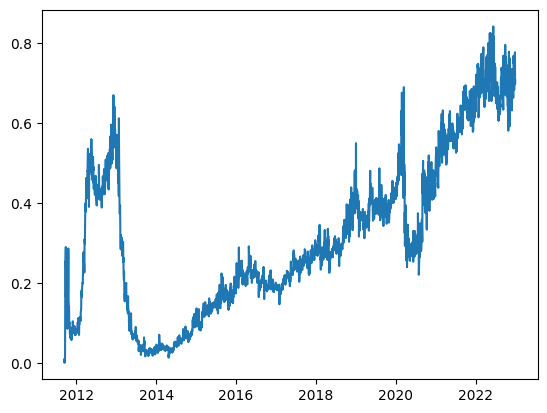

In [4]:
Errors = pd.DataFrame() #collect errors
Errors["CAPM"] = merged_data["Tracking_Error"]
import numpy as np

Errors["CAPM"] = np.square(Errors["CAPM"])
# plot tracking error
plt.plot(Errors["CAPM"])


**Let's put more factors inside our model**

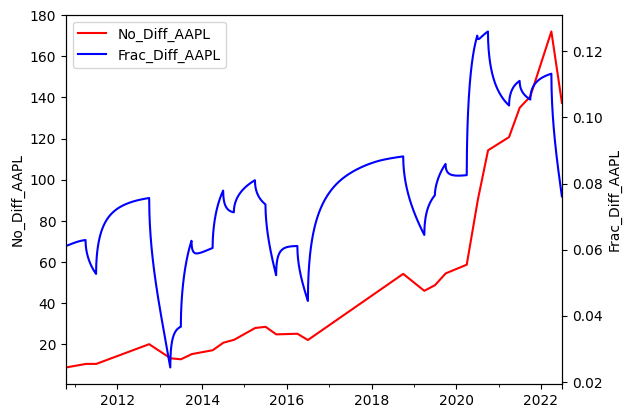

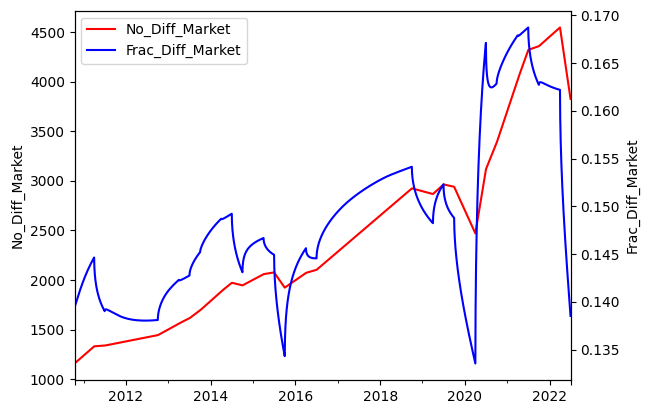

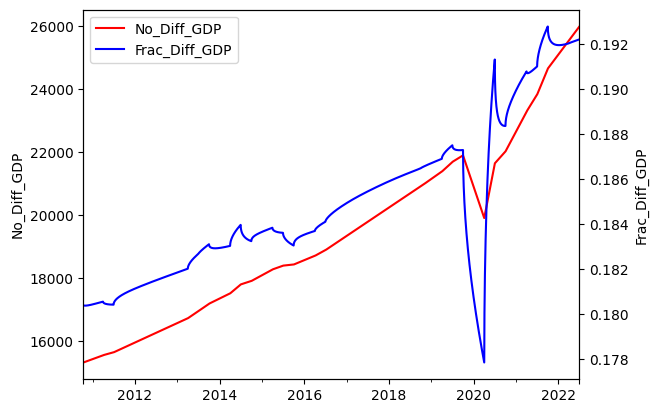

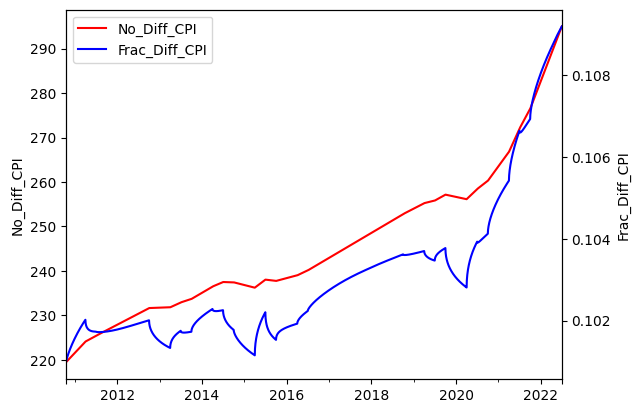

In [5]:
import pandas_datareader as pdr
#collect more factors

# Define the series codes for the macroeconomic data you want to collect
series_codes = ['GDP', 'CPIAUCSL', 'UNRATE']

# Set the start and end dates for the data
start_date = '2000-01-01'
end_date = '2023-12-31'

# Retrieve the macroeconomic data from FRED
macro_data = pdr.DataReader(series_codes, 'fred', start_date, end_date)

macro_data

macro_data = macro_data.rename(columns={"GDP": "GDP", "CPIAUCSL": "CPI", "UNRATE": "Unem_Rate"})
macro_data
macro_data.dropna(inplace=True)
macro_data
base_data=base_data[['AAPL', 'Market']]
base_data

merged_data = pd.merge(base_data, macro_data, left_index=True, right_index=True)
merged_data.head()

merged_data = merged_data.resample('D').interpolate(method='linear')
merged_data
merged_columns = ['AAPL','Market','GDP','CPI']  # Replace with your desired columns

for column in merged_columns:
    fractional_returns = frac_diff_ffd(merged_data[column].apply(np.log).values, d=0.5)
    merged_data[f'Frac_Diff_{column}'] = fractional_returns
    merged_data[f'No_Diff_{column}'] = merged_data[column]
    current_df=merged_data[[f'No_Diff_{column}', f'Frac_Diff_{column}']]
    # Assuming 'column_name' is the name of your column
    first_non_zero_index = current_df[f'Frac_Diff_{column}'].ne(0).idxmax()
    current_df = current_df.loc[first_non_zero_index:]
    plot_multi(current_df)
    plt.show()


**We have new fractionally differentiated our new data**

In [6]:
merged_data
merged_data=merged_data[['Frac_Diff_AAPL', 'Frac_Diff_Market', 'Frac_Diff_GDP', 'Frac_Diff_CPI', 'Unem_Rate']]
# Find the first non-zero index for each column
first_non_zero_indices = merged_data.ne(0).idxmax()

# Get the maximum index among all columns
first_non_zero_index = first_non_zero_indices.max()

# Slice the dataframe from the first non-zero index onwards
merged_data = merged_data.loc[first_non_zero_index:]

merged_data
# List of columns to apply the code block
columns_to_apply = [col for col in merged_data.columns if col != 'Frac_Diff_AAPL']

for column in columns_to_apply:
    # lag frac diff market column
    merged_data[f"Lagged_{column}_lag"] = merged_data[column].shift(1)
    # remove first row
    merged_data = merged_data.iloc[1:]
    # replace fracdiff market column with lagged fracdiff market column
    merged_data[column] = merged_data[f"Lagged_{column}_lag"]
    # drop lagged fracdiff market column
    merged_data = merged_data.drop(columns=[f"Lagged_{column}_lag"])
    # rename fracdiff market column to lagged fracdiff market column
    merged_data = merged_data.rename(columns={column: f"Lagged_{column}"})

merged_data


# List of columns to normalize
columns_to_normalize = merged_data.columns

#Apply normalization to each column
for column in columns_to_normalize:
    merged_data[column] = (merged_data[column] - merged_data[column].mean()) / merged_data[column].std()
    
merged_data



,Frac_Diff_AAPL,Lagged_Frac_Diff_Market,Lagged_Frac_Diff_GDP,Lagged_Frac_Diff_CPI,Lagged_Unem_Rate
2010-10-18,-0.784560,-1.044933,-1.299623,-1.130677,1.458544
2010-10-19,-0.783932,-1.040634,-1.299888,-1.124704,1.457796
2010-10-20,-0.783293,-1.036280,-1.300118,-1.118864,1.457047
2010-10-21,-0.782645,-1.031878,-1.300317,-1.113146,1.456299
2010-10-22,-0.781989,-1.027437,-1.300486,-1.107542,1.455551
...,...,...,...,...,...
2022-06-27,-0.004995,-1.068492,2.108539,3.327551,-1.203371
2022-06-28,-0.017144,-1.087321,2.109042,3.330426,-1.204369
2022-06-29,-0.029272,-1.106108,2.109545,3.333295,-1.205367
2022-06-30,-0.041378,-1.124856,2.110046,3.336159,-1.206365


**We shall now run a regression with Market, GDP, CPI and Unemployment Rate as factors**

In [56]:
after_pca_data=merged_data
merged_data["Alpha"] = 0
merged_data["R_squared"] = 0
merged_data["Beta_Market"] = 0
merged_data["Beta_GDP"] = 0
merged_data["Beta_CPI"] = 0 
merged_data["Beta_UnemRate"] = 0
merged_data["p_value_Alpha"] = 0
merged_data["p_value_Market"] = 0
merged_data["p_value_GDP"] = 0
merged_data["p_value_CPI"] = 0
merged_data["p_value_UnemRate"] = 0

import statsmodels.api as sm

# List of columns to regress against Frac_Diff_AAPL
columns_to_regress = ['Lagged_Frac_Diff_Market','Lagged_Frac_Diff_GDP','Lagged_Frac_Diff_CPI','Lagged_Unem_Rate']

LookBack_Window=96
for x in range(0, len(merged_data)-LookBack_Window-1):
    # Define the independent variables (X) and dependent variable (y)
    X = merged_data[['Lagged_Frac_Diff_Market','Lagged_Frac_Diff_GDP','Lagged_Frac_Diff_CPI','Lagged_Unem_Rate']][x:x+LookBack_Window]
    y = merged_data['Frac_Diff_AAPL'][x:x+LookBack_Window]

    # Add a constant term to the independent variables
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()

    # Get the coefficients
    coefficients = results.params
    # Get the coefficients
    merged_data.loc[merged_data.index[x+1+LookBack_Window], 'Alpha'] = results.params[0]
    merged_data.loc[merged_data.index[x+1+LookBack_Window], 'Beta_Market'] = results.params[1]
    merged_data.loc[merged_data.index[x+1+LookBack_Window], 'Beta_GDP'] = results.params[2]
    merged_data.loc[merged_data.index[x+1+LookBack_Window], 'Beta_CPI'] = results.params[3]
    merged_data.loc[merged_data.index[x+1+LookBack_Window], 'Beta_UnemRate'] = results.params[4]
    merged_data.loc[merged_data.index[x+1+LookBack_Window], 'R_squared'] = results.rsquared
    merged_data.loc[merged_data.index[x+1+LookBack_Window], 'p_value_Alpha'] = results.pvalues[0]
    merged_data.loc[merged_data.index[x+1+LookBack_Window], 'p_value_Market'] = results.pvalues[1]
    merged_data.loc[merged_data.index[x+1+LookBack_Window], 'p_value_GDP'] = results.pvalues[2]
    merged_data.loc[merged_data.index[x+1+LookBack_Window], 'p_value_CPI'] = results.pvalues[3]
    merged_data.loc[merged_data.index[x+1+LookBack_Window], 'p_value_UnemRate'] = results.pvalues[4]
    #merged_data.loc[merged_data.index[x+1+2], 'p_value_CPI'] = results.pvalues[3]
    #merged_data.loc[merged_data.index[x+1+2], 'p_value_UnemRate'] = results.pvalues[4]

    #print(len(results.params))
    #print(len(results.pvalues))

#for x in range(0, len(merged_data)-3):
    # Define the independent variables (X) and dependent variable (y)
    #X = merged_data[['Lagged_Frac_Diff_Market','Lagged_Frac_Diff_GDP','Lagged_Frac_Diff_CPI','Lagged_Unem_Rate']][:x+2]
    #y = merged_data['Frac_Diff_AAPL'][:x+2]






merged_data["Expected_Return"] = merged_data.filter(like="Beta").sum(axis=1)
merged_data["Tracking_Error"] = merged_data["Expected_Return"] - merged_data["Frac_Diff_AAPL"]
# Find the first non-zero and non-NaN index in the "p_value_alpha" column
first_non_zero_index = merged_data['p_value_Alpha'].ne(0).idxmax()
# Remove the rows before the first non-zero and non-NaN index
merged_data = merged_data.loc[first_non_zero_index:]
#drop the first row
merged_data = merged_data.iloc[1:]
merged_data


,Frac_Diff_AAPL,Lagged_Frac_Diff_Market,Lagged_Frac_Diff_GDP,Lagged_Frac_Diff_CPI,Lagged_Unem_Rate,Alpha,R_squared,Beta_Market,Beta_GDP,Beta_CPI,Beta_UnemRate,p_value_Alpha,p_value_Market,p_value_GDP,p_value_CPI,p_value_UnemRate,Expected_Return,Tracking_Error
2013-03-23,-2.496144,-0.734136,-0.832820,-0.947477,0.658223,70.367111,1.000000,-0.338355,471.100260,9.787512,499.076275,2.170684e-87,3.301599e-08,1.014017e-96,6.608924e-81,1.198252e-97,979.625692,982.121836
2013-03-24,-2.505908,-0.732850,-0.832295,-0.948269,0.657724,70.681990,1.000000,-0.352343,472.968912,9.808675,500.977053,1.727239e-91,1.488765e-09,6.583654e-101,1.807316e-84,8.047816e-102,983.402297,985.908206
2013-03-25,-2.515684,-0.731568,-0.831770,-0.949057,0.657225,70.987846,1.000000,-0.364492,474.773723,9.830606,502.813922,2.140240e-94,1.721770e-10,6.596323e-104,8.489115e-87,8.389904e-105,987.053759,989.569443
2013-03-26,-2.525470,-0.730289,-0.831245,-0.949841,0.656726,71.309732,1.000000,-0.373202,476.646992,9.857402,504.723895,4.407781e-96,8.257675e-11,1.088062e-105,7.342666e-88,1.449582e-106,990.855088,993.380559
2013-03-27,-2.535269,-0.729014,-0.830720,-0.950621,0.656228,71.664469,1.000000,-0.377217,478.676505,9.891972,506.798075,1.114509e-96,1.817535e-10,2.179193e-106,8.683936e-88,3.063877e-107,994.989336,997.524604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27,-0.004995,-1.068492,2.108539,3.327551,-1.203371,-1.679021,0.999282,0.681693,1.568796,2.412863,7.428400,9.266140e-01,2.401994e-76,8.938008e-01,3.183376e-01,4.655636e-06,12.091752,12.096747
2022-06-28,-0.017144,-1.087321,2.109042,3.330426,-1.204369,-11.764830,0.999296,0.683648,8.139704,1.394591,7.742551,5.194430e-01,1.621712e-77,4.900471e-01,5.576029e-01,1.233426e-06,17.960494,17.977639
2022-06-29,-0.029272,-1.106108,2.109545,3.333295,-1.205367,-23.696102,0.999314,0.686739,15.918051,0.252008,8.294126,1.980790e-01,1.080346e-78,1.813494e-01,9.141698e-01,1.783667e-07,25.150924,25.180196
2022-06-30,-0.041378,-1.124856,2.110046,3.336159,-1.206365,-38.271588,0.999337,0.691695,25.422260,-1.065831,9.186220,4.112780e-02,1.029767e-79,3.630120e-02,6.430052e-01,1.222162e-08,34.234343,34.275721


**Let's look at our tracking error**

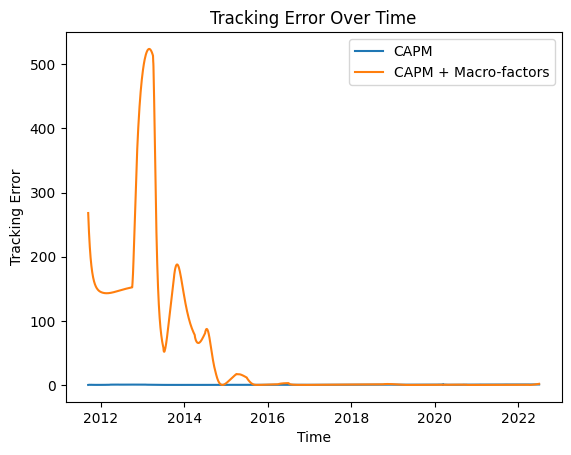

In [ ]:
import matplotlib.pyplot as plt


Errors["Before_PCA"] = merged_data["Tracking_Error"]

Errors["Before_PCA"] = np.square(Errors["Before_PCA"])
#delete NaN values
Errors.dropna(inplace=True)
Errors

# Plotting the columns "CAPM" and "Before_PCA" into one chart
plt.plot(Errors["CAPM"], label="CAPM")
plt.plot(Errors["Before_PCA"], label="CAPM + Macro-factors")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Tracking Error")
plt.title("Tracking Error Over Time")
plt.show()


**We see our macrofactors are seem to just add noise to the system. We investigate**
**Suppose we suspect that Market and GDP are almost the same factor, we run PCA analysis to study this**

In [ ]:
factors=after_pca_data[['Lagged_Frac_Diff_Market', 'Lagged_Frac_Diff_GDP', 'Lagged_Frac_Diff_CPI', 'Lagged_Unem_Rate']]

from sklearn.decomposition import PCA
num_pc = 3 #take 3 instead of 4 factors

X = np.asarray(factors)
[n,m] = X.shape
#print('The number of timestamps is {}.'.format(n))
print('The number of factors is {}.'.format(m))

pca = PCA(n_components=num_pc) # number of principal components
pca.fit(X)

percentage =  pca.explained_variance_ratio_
percentage_cum = np.cumsum(percentage)
print('{0:.2f}% of the variance is explained by the first 2 PCs'.format(percentage_cum[-1]*100))

pca_components = pca.components_


The number of factors is 4.
99.17% of the variance is explained by the first 2 PCs


**We see our suspicion is correct in fact it could be the case that we only need 2 not 3**

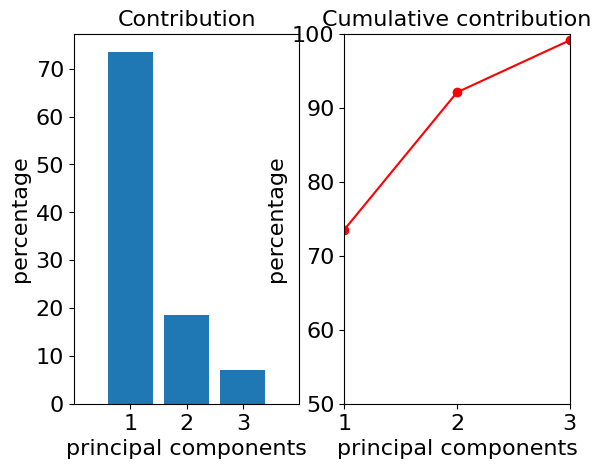

In [ ]:

x = np.arange(1,len(percentage)+1,1)

plt.subplot(1, 2, 1)
plt.bar(x, percentage*100, align = "center")
plt.title('Contribution',fontsize = 16)
plt.xlabel('principal components',fontsize = 16)
plt.ylabel('percentage',fontsize = 16)
plt.xticks(x,fontsize = 16) 
plt.yticks(fontsize = 16)
plt.xlim([0, num_pc+1])

plt.subplot(1, 2, 2)
plt.plot(x, percentage_cum*100,'ro-')
plt.xlabel('principal components',fontsize = 16)
plt.ylabel('percentage',fontsize = 16)
plt.title('Cumulative contribution',fontsize = 16)
plt.xticks(x,fontsize = 16) 
plt.yticks(fontsize = 16)
plt.xlim([1, num_pc])
plt.ylim([50,100]);


C:\Users\clint\AppData\Local\Temp\ipykernel_15784\503030108.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


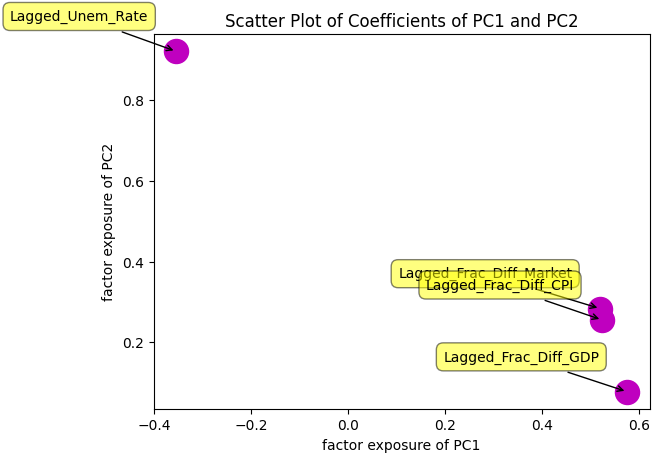

In [ ]:

factor_returns = X.dot(pca_components.T)
factor_returns = pd.DataFrame(columns=["factor 1", "factor 2","factor 3"], 
                              index=factors.index,
                              data=factor_returns)
factor_returns.head()

factor_exposures = pd.DataFrame(index=["factor 1", "factor 2","factor 3"], 
                                columns=factors.columns,
                                data = pca.components_).T
factor_exposures
labels = factor_exposures.index
data = factor_exposures.values

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    data[:, 0], data[:, 1], marker='o', s=300, c='m',
    cmap=plt.get_cmap('Spectral'))
plt.title('Scatter Plot of Coefficients of PC1 and PC2')
plt.xlabel('factor exposure of PC1')
plt.ylabel('factor exposure of PC2')

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    );

**We see here that Market and CPI are almost similar to each other. We shall remove CPI and keep market only in our regression** 

In [ ]:
merged_data = after_pca_data[['Frac_Diff_AAPL', 'Lagged_Frac_Diff_Market', 'Lagged_Frac_Diff_GDP', 'Lagged_Unem_Rate']]
merged_data

,Frac_Diff_AAPL,Lagged_Frac_Diff_Market,Lagged_Frac_Diff_GDP,Lagged_Unem_Rate
2010-10-18,-0.784559,-1.044933,-1.299623,1.458544
2010-10-19,-0.783931,-1.040634,-1.299888,1.457796
2010-10-20,-0.783292,-1.036280,-1.300118,1.457047
2010-10-21,-0.782644,-1.031878,-1.300317,1.456299
2010-10-22,-0.781988,-1.027437,-1.300486,1.455551
...,...,...,...,...
2022-06-27,-0.004995,-1.068492,2.108539,-1.203371
2022-06-28,-0.017144,-1.087321,2.109042,-1.204369
2022-06-29,-0.029272,-1.106108,2.109545,-1.205367
2022-06-30,-0.041378,-1.124856,2.110046,-1.206365


In [ ]:
# List of columns to regress against Frac_Diff_AAPL
columns_to_regress = ['Lagged_Frac_Diff_Market','Lagged_Frac_Diff_GDP','Lagged_Unem_Rate']


merged_data["Alpha"] = 0
merged_data["R_squared"] = 0
merged_data["Beta_Market"] = 0
merged_data["Beta_GDP"] = 0
merged_data["Beta_UnemRate"] = 0
merged_data["p_value_Alpha"] = 0
merged_data["p_value_Market"] = 0
merged_data["p_value_GDP"] = 0
merged_data["p_value_UnemRate"] = 0

for x in range(0, len(merged_data)-3):
    # Define the independent variables (X) and dependent variable (y)
    X = merged_data[['Lagged_Frac_Diff_Market','Lagged_Frac_Diff_GDP','Lagged_Unem_Rate']][:x+2]
    y = merged_data['Frac_Diff_AAPL'][:x+2]

    # Add a constant term to the independent variables
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()

    # Get the coefficients
    coefficients = results.params

    # Get the coefficients
    merged_data.loc[merged_data.index[x+1+2], 'Alpha'] = results.params[0]
    merged_data.loc[merged_data.index[x+1+2], 'Beta_Market'] = results.params[1]
    merged_data.loc[merged_data.index[x+1+2], 'Beta_GDP'] = results.params[2]
    
    merged_data.loc[merged_data.index[x+1+2], 'Beta_UnemRate'] = results.params[3]
    merged_data.loc[merged_data.index[x+1+2], 'R_squared'] = results.rsquared
    merged_data.loc[merged_data.index[x+1+2], 'p_value_Alpha'] = results.pvalues[0]
    merged_data.loc[merged_data.index[x+1+2], 'p_value_Market'] = results.pvalues[1]
    merged_data.loc[merged_data.index[x+1+2], 'p_value_GDP'] = results.pvalues[2]
    
    merged_data.loc[merged_data.index[x+1+2], 'p_value_UnemRate'] = results.pvalues[3]

merged_data["Expected_Return"] = merged_data.filter(like="Beta").sum(axis=1)
merged_data["Tracking_Error"] = merged_data["Expected_Return"] - merged_data["Frac_Diff_AAPL"]
# Find the first non-zero and non-NaN index in the "p_value_alpha" column
first_non_zero_index = merged_data['p_value_Alpha'].ne(0).idxmax()
# Remove the rows before the first non-zero and non-NaN index
merged_data = merged_data.loc[first_non_zero_index:]
#drop the first row
merged_data = merged_data.iloc[1:]
full_data=merged_data
merged_data

C:\Users\clint\AppData\Local\Temp\ipykernel_15784\1014284583.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data["Alpha"] = 0
C:\Users\clint\AppData\Local\Temp\ipykernel_15784\1014284583.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data["R_squared"] = 0
C:\Users\clint\AppData\Local\Temp\ipykernel_15784\1014284583.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,Frac_Diff_AAPL,Lagged_Frac_Diff_Market,Lagged_Frac_Diff_GDP,Lagged_Unem_Rate,Alpha,R_squared,Beta_Market,Beta_GDP,Beta_UnemRate,p_value_Alpha,p_value_Market,p_value_GDP,p_value_UnemRate,Expected_Return,Tracking_Error
2010-10-22,-0.781988,-1.027437,-1.300486,1.455551,-0.156053,1.000000,0.112157,0.124845,-0.239319,NaN,NaN,NaN,NaN,-0.002317,0.779671
2010-10-23,-0.781326,-1.022963,-1.300628,1.454802,-0.315023,1.000000,0.127683,0.099994,-0.141348,NaN,NaN,NaN,NaN,0.086329,0.867654
2010-10-24,-0.780657,-1.018462,-1.300746,1.454054,-0.326454,1.000000,0.128809,0.098246,-0.134261,0.009237,2.333079e-03,4.546479e-03,1.403818e-02,0.092794,0.873451
2010-10-25,-0.779983,-1.013937,-1.300840,1.453305,-0.336761,1.000000,0.129833,0.096707,-0.127832,0.000164,1.119488e-05,4.126245e-05,4.516017e-04,0.098707,0.878690
2010-10-26,-0.779305,-1.009395,-1.300913,1.452557,-0.346091,1.000000,0.130768,0.095346,-0.121978,0.000004,7.465220e-08,4.998346e-07,2.230637e-05,0.104135,0.883440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27,-0.004995,-1.068492,2.108539,-1.203371,0.000537,0.703790,0.399646,0.575989,0.346581,0.948635,8.988945e-91,2.193528e-146,1.017969e-213,1.322215,1.327210
2022-06-28,-0.017144,-1.087321,2.109042,-1.204369,0.000445,0.703758,0.400992,0.574481,0.346351,0.957424,2.863318e-92,3.797580e-147,1.074594e-213,1.321825,1.338969
2022-06-29,-0.029272,-1.106108,2.109545,-1.205367,0.000354,0.703726,0.402333,0.572982,0.346123,0.966124,8.731381e-94,6.519247e-148,1.136672e-213,1.321437,1.350709
2022-06-30,-0.041378,-1.124856,2.110046,-1.206365,0.000264,0.703694,0.403666,0.571492,0.345895,0.974733,2.548898e-95,1.109828e-148,1.204686e-213,1.321053,1.362431


In [ ]:
Errors["After_PCA"] = np.square(merged_data["Tracking_Error"])
Errors

,CAPM,Before_PCA,After_PCA
Date,,,
2011-09-12,0.001615,268.135779,144.710099
2011-09-13,0.009721,263.274517,144.668967
2011-09-14,0.003709,258.604666,144.627663
2011-09-15,0.001805,254.120206,144.586210
2011-09-16,0.001073,249.815029,144.544632
...,...,...,...
2022-06-27,0.689678,1.593892,1.761487
2022-06-28,0.747453,1.623646,1.792839
2022-06-29,0.702872,1.653629,1.824415


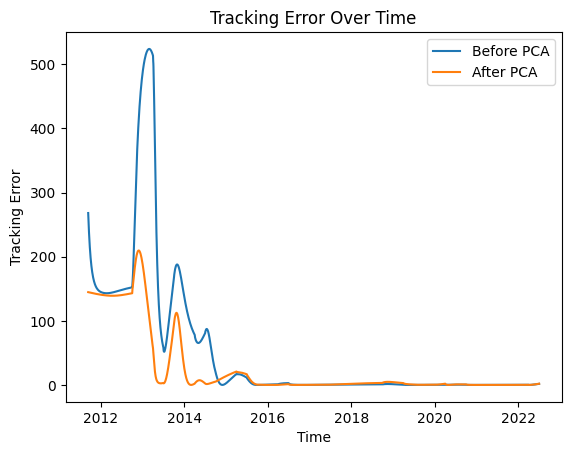

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Errors.index, Errors["Before_PCA"], label="Before PCA")
plt.plot(Errors.index, Errors["After_PCA"], label="After PCA")
plt.xlabel("Time")
plt.ylabel("Tracking Error")
plt.title("Tracking Error Over Time")
plt.legend()
plt.show()


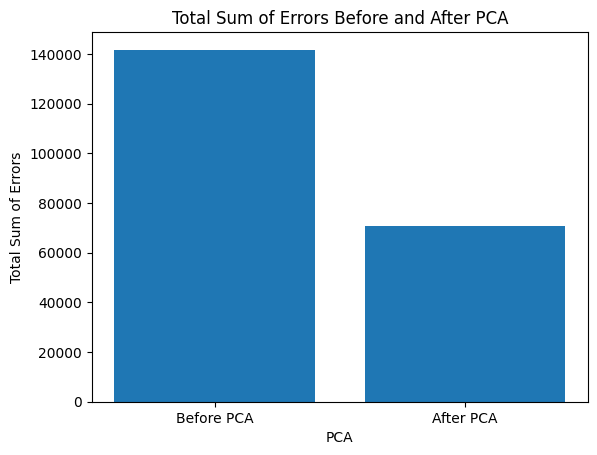

In [ ]:
# Calculate the total sum of errors before and after PCA
total_sum_error_before_pca = Errors["Before_PCA"].sum()
total_sum_error_after_pca = Errors["After_PCA"].sum()

# Create a bar plot
plt.bar(["Before PCA", "After PCA"], [total_sum_error_before_pca, total_sum_error_after_pca])
plt.xlabel("PCA")
plt.ylabel("Total Sum of Errors")
plt.title("Total Sum of Errors Before and After PCA")
plt.show()


**We have now improved (reduced out errors) our model through PCA. Let us now study possible dates where our model would have predicted signficant results.**

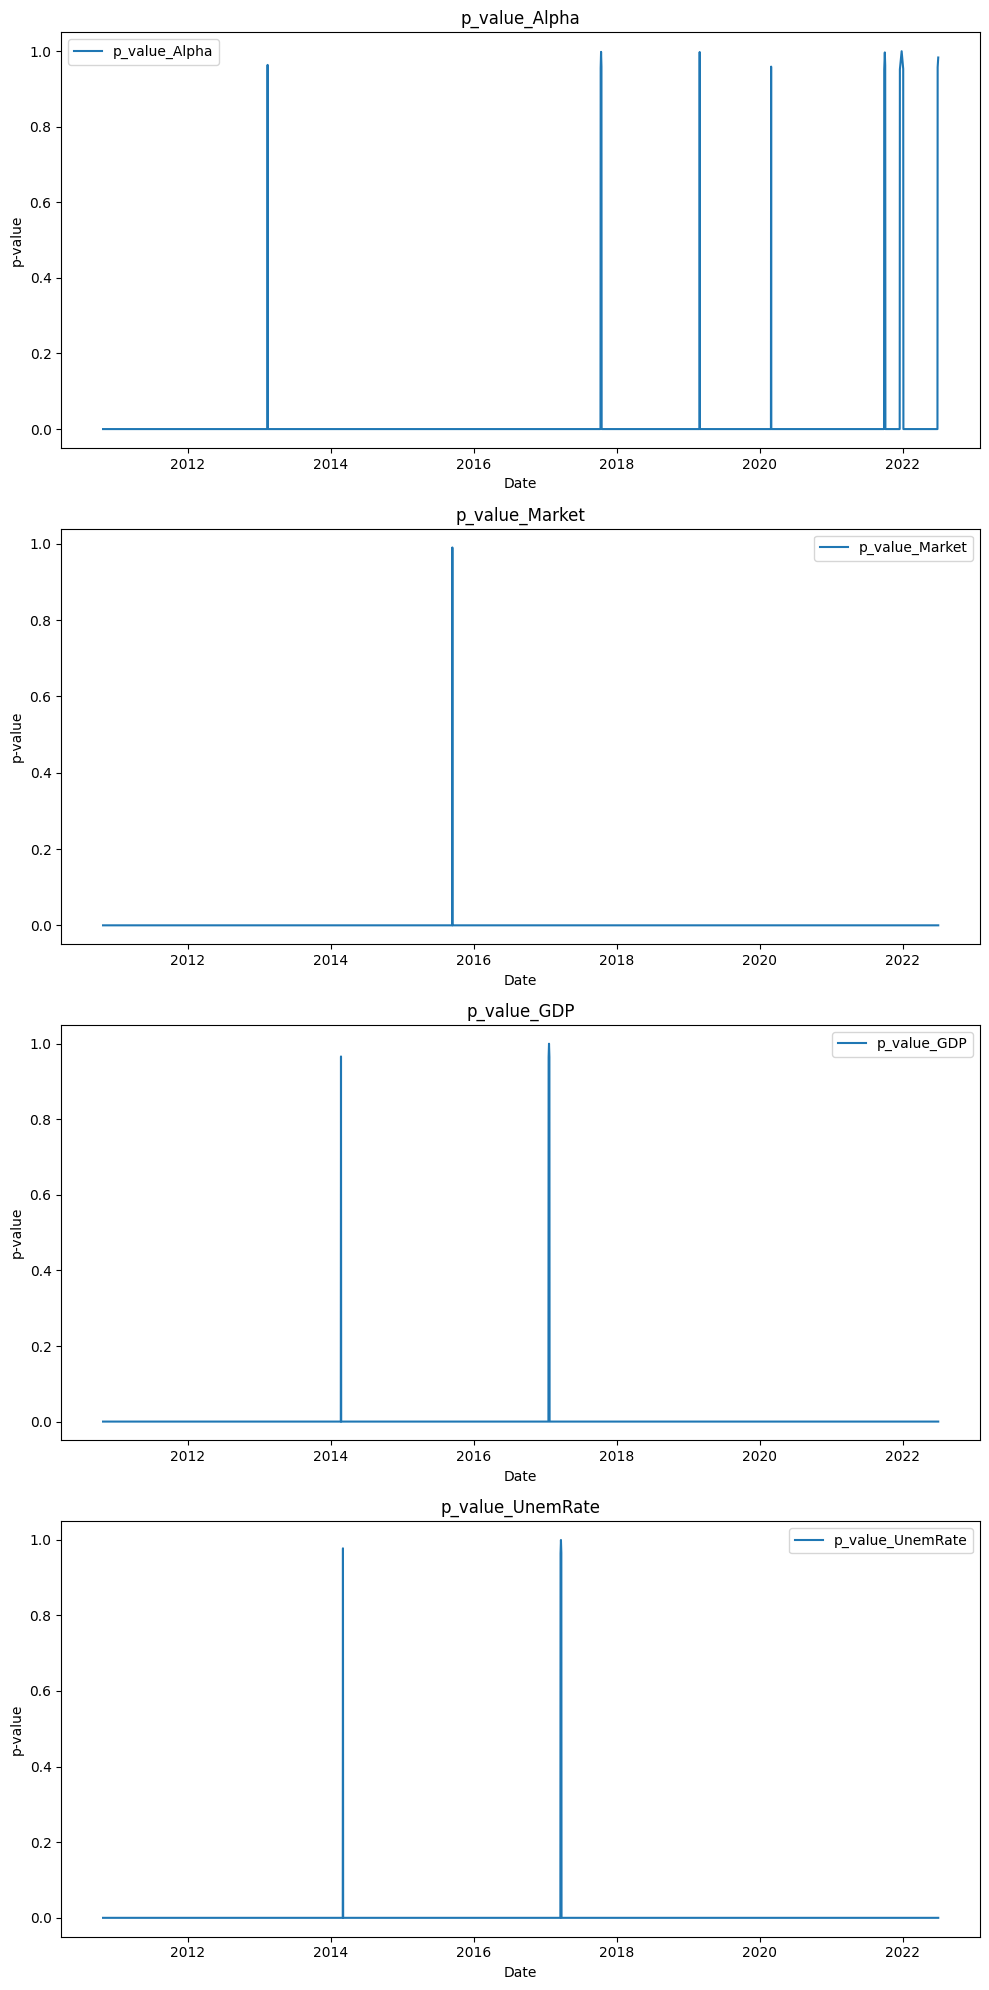

In [ ]:
import matplotlib.pyplot as plt

# Get the columns that start with "p_value"
p_value_columns = [col for col in merged_data.columns if col.startswith("p_value")]

# Modify each column
for column in p_value_columns:
    merged_data[column] = merged_data[column].apply(lambda x: 0 if x < 0.95 else x)


# Create subplots for each modified column
fig, axes = plt.subplots(len(p_value_columns), 1, figsize=(10, 5 * len(p_value_columns)))

# Plot each modified column in a separate box
for i, column in enumerate(p_value_columns):
    axes[i].plot(merged_data.index, merged_data[column], label=column)
    axes[i].set_title(column)
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("p-value")
    axes[i].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


**GDP and Unemployment seem to be highly related with each other, which makes sense because of the Phillips Curve. Future work needs to be done analyzing there significance in the model. Our model predicts signifcant $\alpha$ between 2021-2022, which makes sense as this is when markets were reoerienting themselves.**